In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install afinn
!pip install -U transformers datasets accelerate evaluate
!pip install transformers datasets evaluate accelerate shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53431 sha256=58a6319db4831c5c21e50ab7d01fe086ce84875e4ab8f17a325e430ec1c6c47a
  Stored in directory: /root/.cache/pip/wheels/f9/72/27/74994e77200dae3d6aea2b546264500cee21f738c51241320b
Successfully built afinn
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 50.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Suc

In [ ]:
# ==============================
# ENVIRONMENT SETUP
# ==============================
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ==============================
# LOAD SWMH DATA
# ==============================
train_path = "/content/drive/MyDrive/Mansoor_Share/Datasets/RMHD_combined/RMHD_combinedsorted_train.csv"
val_path   = "/content/drive/MyDrive/Mansoor_Share/Datasets/RMHD_combined/RMHD_combinedsorted_val.csv"
test_path  = "/content/drive/MyDrive/Mansoor_Share/Datasets/RMHD_combined/RMHD_combinedsorted_test.csv"


df_train = pd.read_csv(train_path)
df_val   = pd.read_csv(val_path)
df_test  = pd.read_csv(test_path)

# Basic checks
print("===train===")
print(df_train['label'].value_counts())
print("===val===")
print(df_val['label'].value_counts())
print("===test===")
print(df_test['label'].value_counts())


Using device: cuda
===train===
label
Depression       43567
Anxiety          16349
ADHD             11500
BPD               5485
SocialAnxiety     5236
PTSD              1576
HealthAnxiety     1475
Bipolar           1269
Name: count, dtype: int64
===val===
label
Depression       7261
Anxiety          2725
ADHD             1916
BPD               914
SocialAnxiety     872
PTSD              263
HealthAnxiety     246
Bipolar           212
Name: count, dtype: int64
===test===
label
Depression       7261
Anxiety          2725
ADHD             1917
BPD               915
SocialAnxiety     873
PTSD              262
HealthAnxiety     246
Bipolar           211
Name: count, dtype: int64


In [ ]:


# ==============================
# TEXT CLEANING
# ==============================
import re

def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^A-Za-z0-9\s.,!?']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

for df in [df_train, df_val, df_test]:
    df["text"] = df["text"].apply(clean_text)


# ==============================
# LABEL MAPPING
# ==============================
label2id = {l: i for i, l in enumerate(sorted(df_train['label'].unique()))}
id2label = {v: k for k, v in label2id.items()}

for df in [df_train, df_val, df_test]:
    df["label_id"] = df["label"].map(label2id)



In [ ]:
from afinn import Afinn
import numpy as np

af = Afinn()

def compute_emotion_score(text):
    text = text.lower()
    tokens = text.split()

    scores = []
    for tok in tokens:
        val = af.score(tok)
        if val < 0:               # only consider negative words
            # normalize from [-5,0] to [1,0]
            norm = abs(val) / 5.0
            scores.append(norm)

    if not scores:
        return 0.0   # positive or neutral text → intensity = 0

    return float(np.mean(scores))


In [ ]:

# ==============================
# APPLY EMOTION SCORE TO DATASETS
# ==============================
for df in [df_train, df_val, df_test]:
    df["emotion_score"] = df["text"].apply(compute_emotion_score)


# ==============================
# BUILD DATASETDICT
# ==============================
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train[["text", "label_id", "emotion_score"]]),
    "validation": Dataset.from_pandas(df_val[["text", "label_id", "emotion_score"]]),
    "test": Dataset.from_pandas(df_test[["text", "label_id", "emotion_score"]])
})


In [ ]:
# ==============================
# INSPECT SAMPLE SCORES
# ==============================

print("\n=== TRAIN SAMPLE ===")
for i in range(5):
    print(f"\nText: {df_train.iloc[i]['text']}")
    print(f"Label: {df_train.iloc[i]['label_id']}")
    print(f"Emotion Score: {df_train.iloc[i]['emotion_score']:.4f}")

print("\n=== VALIDATION SAMPLE ===")
for i in range(5):
    print(f"\nText: {df_val.iloc[i]['text']}")
    print(f"Label: {df_val.iloc[i]['label_id']}")
    print(f"Emotion Score: {df_val.iloc[i]['emotion_score']:.4f}")

print("\n=== TEST SAMPLE ===")
for i in range(5):
    print(f"\nText: {df_test.iloc[i]['text']}")
    print(f"Label: {df_test.iloc[i]['label_id']}")
    print(f"Emotion Score: {df_test.iloc[i]['emotion_score']:.4f}")



=== TRAIN SAMPLE ===

Text: loneliness sucks stupid vent this website seemed to be the only place where people might possibly listen to my idiotic vent, but i just want to get some things off of my chest. amp x200b over the past couple of months my depression has increased dramatically and its been very hard to deal with it in my everyday life in my opinion a couple of months ago i was doing ok, i stopped cutting myself which is good and i had a lot of support from friends. however recently i have noticed that one by one they left me and slowly stopped talking to me. i would go days on end with barely having an actually conversation with someone. people stopped talking to me at lunch as they focused on topics i'm relatively in to. i was left out the the conversation and those are practically my only friends. later on my friends exclude me from group project which was basically every assignment in my school and i was left alone, nobody around me, i felt utterly awful about myself. i st

In [ ]:
# ==============================
# TOKENIZATION (RoBERTa + emotion score)
# ==============================
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-large")

def tokenize_fn(batch):
    tok = tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

    tok["labels"] = batch["label_id"]      # CE labels
    tok["emotion_score"] = batch["emotion_score"]  # regression labels

    return tok

tokenized = dataset.map(tokenize_fn, batched=True)

tokenized.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels", "emotion_score"]
)

print(tokenized)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/86457 [00:00<?, ? examples/s]

Map:   0%|          | 0/14409 [00:00<?, ? examples/s]

Map:   0%|          | 0/14410 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label_id', 'emotion_score', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 86457
    })
    validation: Dataset({
        features: ['text', 'label_id', 'emotion_score', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14409
    })
    test: Dataset({
        features: ['text', 'label_id', 'emotion_score', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14410
    })
})


In [ ]:
import numpy as np
import torch

# Count frequencies on train set
class_counts = df_train['label_id'].value_counts().sort_index().values
total = class_counts.sum()

# Inverse frequency weighting
class_weights = total / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print("Class weights:", class_weights)


Class weights: tensor([0.9398, 0.6610, 1.9703, 8.5163, 0.2481, 7.3269, 6.8573, 2.0640])


In [ ]:
def collate_fn(batch):
    return {
        "input_ids": torch.stack([x["input_ids"] for x in batch]),
        "attention_mask": torch.stack([x["attention_mask"] for x in batch]),
        "labels": torch.tensor([x["labels"] for x in batch]),
        "emotion_score": torch.tensor([x["emotion_score"] for x in batch])
    }


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from transformers import AutoModel, AutoConfig

import torch
from torch import nn
import torch.nn.functional as F
from transformers import AutoModel, AutoConfig

class RobertaSWMHClassifier(nn.Module):
    def __init__(self, num_labels, class_weights, temperature=0.07):
        super().__init__()

        self.config = AutoConfig.from_pretrained(
            "roberta-large",
            num_labels=num_labels,
            output_hidden_states=False
        )

        self.encoder = AutoModel.from_pretrained("roberta-large", config=self.config)
        self.dropout = nn.Dropout(0.3)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.config.hidden_size, 128),
            nn.GELU(),
            nn.LayerNorm(128),
            nn.Dropout(0.2),
            nn.GELU(),
            nn.Linear(128, num_labels)
        )

        # Regression head
        self.regressor = nn.Linear(self.config.hidden_size, 1)

        # Projection head for contrastive learning
        self.proj = nn.Sequential(
            nn.Linear(self.config.hidden_size, 128),
            nn.GELU(),
            nn.Linear(128, 64)
        )

        # class weights
        self.register_buffer("class_weights", class_weights)

        self.ce_loss = nn.CrossEntropyLoss(weight=self.class_weights)
        self.mse_loss = nn.MSELoss()
        self.temperature = temperature

    # --------------------------------------------------------
    # Supervised contrastive loss for CLS projection
    # --------------------------------------------------------
    def contrastive_loss(self, features, labels):
        features = F.normalize(features, dim=1)  # (B, D)
        sim = torch.matmul(features, features.T) / self.temperature  # (B, B)

        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float()
        mask.fill_diagonal_(0)  # remove self-pair

        exp_sim = torch.exp(sim)
        log_prob = sim - torch.log(exp_sim.sum(dim=1, keepdim=True))

        # only positives
        pos_log_prob = (mask * log_prob).sum(dim=1) / mask.sum(dim=1).clamp(min=1)

        return -pos_log_prob.mean()

    # --------------------------------------------------------
    # Forward pass
    # --------------------------------------------------------
    def forward(self, input_ids=None, attention_mask=None, labels=None, emotion_score=None):

        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]  # CLS

        pooled = self.dropout(pooled)

        logits = self.classifier(pooled)
        emo_pred = self.regressor(pooled).squeeze(-1)

        # projection for contrastive loss
        proj_vec = self.proj(pooled)

        # -------------------------------------
        # TOTAL LOSS
        # -------------------------------------
        loss = None
        if labels is not None:

            ce = self.ce_loss(logits, labels.long())
            scl = self.contrastive_loss(proj_vec, labels.long())

            if emotion_score is not None:
                mse = self.mse_loss(emo_pred, emotion_score.float())
                loss = ce + 0.3 * mse + 0.1 * scl
            else:
                loss = ce + 0.1 * scl

        return {
            "loss": loss,
            "logits": logits,
            "emotion_pred": emo_pred,
            "proj_vec": proj_vec
        }


In [ ]:
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

model = RobertaSWMHClassifier(
    num_labels=len(label2id),
    class_weights=class_weights_tensor
).to(device)


/tmp/ipython-input-3811427058.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# for name, param in model.named_parameters():
#     param.requires_grad = False

# for param in model.classifier.parameters():
#     param.requires_grad = True

# for n, p in model.named_parameters():
#     if p.requires_grad:
#         print("TRAINABLE:", n)
#     else:
#         print("FROZEN:", n)


In [ ]:
# ==============================
# METRICS
# ==============================
import numpy as np
import evaluate
def compute_metrics(eval_pred):
    preds_tuple, labels = eval_pred

    # preds_tuple is (logits, emo_pred)
    logits = preds_tuple[0]

    preds = np.argmax(logits, axis=-1)

    from sklearn.metrics import f1_score, accuracy_score

    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }


In [ ]:
# ==============================
# TRAINING CONFIGURATION (fixed)
# ==============================
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

args = TrainingArguments(
    output_dir="./roberta_large_RMHD_combined8_with_affine_emotion_constructive",
    eval_strategy="epoch",
    save_strategy="epoch",
    dataloader_num_workers=2,
    learning_rate=1e-6,              # Lower LR for deeper head
    weight_decay=0.05,               # Regularization
    warmup_ratio=0.1,                # Smooth LR ramp-up
    lr_scheduler_type="cosine",      # Gentle decay
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    load_best_model_at_end=True,     # Reload best checkpoint (lowest val loss)
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    label_smoothing_factor=0.1,
    fp16=True,
    logging_dir="./logs",
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)



In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.303000,0.871368,0.836907,0.693873
2,0.848300,0.820139,0.860504,0.771995
3,0.803100,0.819558,0.861475,0.774632
4,0.777900,0.820675,0.863696,0.785560


TrainOutput(global_step=43232, training_loss=0.9330696201959775, metrics={'train_runtime': 4841.885, 'train_samples_per_second': 267.841, 'train_steps_per_second': 33.483, 'total_flos': 0.0, 'train_loss': 0.9330696201959775, 'epoch': 4.0})

In [ ]:
# ==============================
# MODEL EVALUATION
# ==============================
results = trainer.evaluate(tokenized["test"])
print(results)

# Save metrics
import json
with open("metrics.json", "w") as f:
    json.dump(results, f, indent=2)


{'eval_loss': 0.8022474050521851, 'eval_accuracy': 0.8700208188757808, 'eval_macro_f1': 0.7913492228051245, 'eval_runtime': 50.6582, 'eval_samples_per_second': 284.456, 'eval_steps_per_second': 35.572, 'epoch': 4.0}



Base evaluation metrics:
{
  "eval_loss": 0.8022474050521851,
  "eval_accuracy": 0.8700208188757808,
  "eval_macro_f1": 0.7913492228051245,
  "eval_runtime": 55.327,
  "eval_samples_per_second": 260.452,
  "eval_steps_per_second": 32.57,
  "epoch": 4.0
}

Accuracy: 0.8700

Confusion Matrix:
[[1794   34    6    0   75    3    0    5]
 [  40 2146   12    3  324   24   15  161]
 [  21   49  614    9  208    0    6    8]
 [  13   12    8  122   53    1    1    1]
 [  49  170   33   10 6945    1   20   33]
 [   1   60    3    0    7  173    0    2]
 [   0   11    4    0   51    0  195    1]
 [   9  179    3    0  132    1    1  548]]

Classification Report:
               precision    recall  f1-score   support

         ADHD       0.93      0.94      0.93      1917
      Anxiety       0.81      0.79      0.80      2725
          BPD       0.90      0.67      0.77       915
      Bipolar       0.85      0.58      0.69       211
   Depression       0.89      0.96      0.92      7261
HealthA

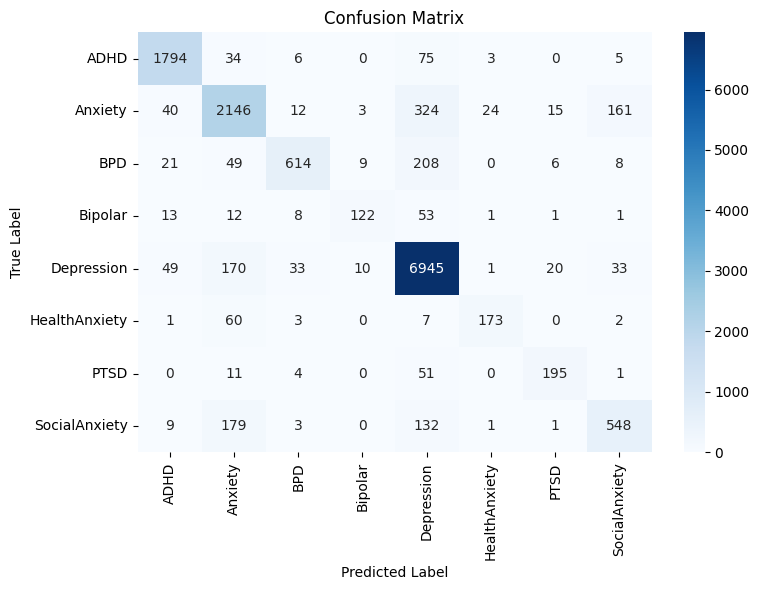

In [ ]:
# ==============================
# MODEL EVALUATION + PLOTS  (FIXED FOR MULTI-TASK MODEL)
# ==============================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import json

# ------------------------------
# Evaluate model
# ------------------------------
results = trainer.evaluate(tokenized["test"])
print("\nBase evaluation metrics:")
print(json.dumps(results, indent=2))


# ------------------------------
# Predictions & Metrics
# ------------------------------
predictions = trainer.predict(tokenized["test"])

# predictions.predictions is a tuple because of multitask:
# (logits, emotion_pred)
logits = predictions.predictions[0]   # <-- FIX
y_pred = np.argmax(logits, axis=-1)
y_true = predictions.label_ids

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(label2id.keys())
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


# ------------------------------
# Plot Confusion Matrix
# ------------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


# ------------------------------
# Save metrics
# ------------------------------
results["accuracy"] = float(acc)
results["confusion_matrix"] = cm.tolist()

with open("metrics.json", "w") as f:
    json.dump(results, f, indent=2)


In [ ]:
from sklearn.metrics import f1_score

overall_f1 = f1_score(y_true, y_pred, average="macro")
print(f"\nOverall Macro F1: {overall_f1:.4f}")
from sklearn.metrics import recall_score

overall_recall = recall_score(y_true, y_pred, average="macro")
print(f"\nOverall Macro Recall: {overall_recall:.4f}")
weighted_recall = recall_score(y_true, y_pred, average="weighted")
print(f"Weighted Recall: {weighted_recall:.4f}")




Overall Macro F1: 0.7913

Overall Macro Recall: 0.7505
Weighted Recall: 0.8700


In [ ]:
# # ==============================
# # SHAP EXPLAINABILITY (TOP 100 SAMPLES)
# # ==============================
# import shap
# subset = df_test.sample(100)
# texts = subset["text"].tolist()
# explainer = shap.Explainer(model, tokenizer)
# shap_values = explainer(texts)
# shap.plots.text(shap_values[0])


In [ ]:
best_checkpoint = trainer.state.best_model_checkpoint
best_checkpoint


'./roberta_large_RMHD_combined8_with_affine_emotion_constructive/checkpoint-32424'

In [ ]:

best_ckpt = trainer.state.best_model_checkpoint
print("Best checkpoint:", best_ckpt)

import os
import shutil

# remove leading "./" to keep clean filename
# zip_name = os.path.basename(best_ckpt)
zip_name = "RMHDCombined8_roberta_large_constructive_learning_affinnemotion_scl_v1"
zip_path = f"/content/{zip_name}.zip"

shutil.make_archive(f"/content/{zip_name}", 'zip', best_ckpt)

print("Created zip:", zip_path)

from google.colab import files
files.download(zip_path)


Best checkpoint: ./roberta_large_RMHD_combined8_with_affine_emotion_constructive/checkpoint-32424
Created zip: /content/RMHDCombined8_roberta_large_constructive_learning_affinnemotion_scl_v1.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os

#  Change this if you want a different folder name
save_dir = "/content/drive/MyDrive/MansoorProposalWork/RMHD_with_emotion"

os.makedirs(save_dir, exist_ok=True)

train_path = os.path.join(save_dir, "RMHD_train_emotion8.csv")
val_path   = os.path.join(save_dir, "RMHD_val_emotion8.csv")
test_path  = os.path.join(save_dir, "RMHD_test_emotion8.csv")

# Save the updated dataframes
df_train.to_csv(train_path, index=False)
df_val.to_csv(val_path, index=False)
df_test.to_csv(test_path, index=False)

print("✅ Files saved to Drive:")
print(train_path)
print(val_path)
print(test_path)


✅ Files saved to Drive:
/content/drive/MyDrive/MansoorProposalWork/RMHD_with_emotion/RMHD_train_emotion8.csv
/content/drive/MyDrive/MansoorProposalWork/RMHD_with_emotion/RMHD_val_emotion8.csv
/content/drive/MyDrive/MansoorProposalWork/RMHD_with_emotion/RMHD_test_emotion8.csv
